TD3 Model
@inproceedings{fujimoto2018addressing,
  title={Addressing Function Approximation Error in Actor-Critic Methods},
  author={Fujimoto, Scott and Hoof, Herke and Meger, David},
  booktitle={International Conference on Machine Learning},
  pages={1582--1591},
  year={2018}
}

In [30]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Implementation of Twin Delayed Deep Deterministic Policy Gradients (TD3)
# Paper: https://arxiv.org/abs/1802.09477


class Actor(nn.Module):
	def __init__(self, state_dim, action_dim, max_action):
		super(Actor, self).__init__()

		self.l1 = nn.Linear(state_dim, 256)
		self.l2 = nn.Linear(256, 256)
		self.l3 = nn.Linear(256, action_dim)
		
		self.max_action = max_action
		

	def forward(self, state):
		a = F.relu(self.l1(state))
		a = F.relu(self.l2(a))
		return self.max_action * torch.tanh(self.l3(a))


class Critic(nn.Module):
	def __init__(self, state_dim, action_dim):
		super(Critic, self).__init__()

		# Q1 architecture
		self.l1 = nn.Linear(state_dim + action_dim, 256)
		self.l2 = nn.Linear(256, 256)
		self.l3 = nn.Linear(256, 1)

		# Q2 architecture
		self.l4 = nn.Linear(state_dim + action_dim, 256)
		self.l5 = nn.Linear(256, 256)
		self.l6 = nn.Linear(256, 1)


	def forward(self, state, action):
		sa = torch.cat([state, action], 1)

		q1 = F.relu(self.l1(sa))
		q1 = F.relu(self.l2(q1))
		q1 = self.l3(q1)

		q2 = F.relu(self.l4(sa))
		q2 = F.relu(self.l5(q2))
		q2 = self.l6(q2)
		return q1, q2


	def Q1(self, state, action):
		sa = torch.cat([state, action], 1)

		q1 = F.relu(self.l1(sa))
		q1 = F.relu(self.l2(q1))
		q1 = self.l3(q1)
		return q1


class TD3(object):
	def __init__(
		self,
		state_dim,
		action_dim,
		max_action,
		discount=0.99,
		tau=0.005,
		policy_noise=0.2,
		noise_clip=0.5,
		policy_freq=2
	):

		self.actor = Actor(state_dim, action_dim, max_action).to(device)
		self.actor_target = copy.deepcopy(self.actor)
		self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=3e-4)

		self.critic = Critic(state_dim, action_dim).to(device)
		self.critic_target = copy.deepcopy(self.critic)
		self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=3e-4)

		self.max_action = max_action
		self.discount = discount
		self.tau = tau
		self.policy_noise = policy_noise
		self.noise_clip = noise_clip
		self.policy_freq = policy_freq

		self.total_it = 0


	def select_action(self, state):
		state = torch.FloatTensor(state.reshape(1, -1)).to(device)
		return self.actor(state).cpu().data.numpy().flatten()


	def train(self, replay_buffer, batch_size=100):
		self.total_it += 1

		# Sample replay buffer 
		state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

		with torch.no_grad():
			# Select action according to policy and add clipped noise
			noise = (
				torch.randn_like(action) * self.policy_noise
			).clamp(-self.noise_clip, self.noise_clip)
			
			next_action = (
				self.actor_target(next_state) + noise
			).clamp(-self.max_action, self.max_action)

			# Compute the target Q value
			target_Q1, target_Q2 = self.critic_target(next_state, next_action)
			target_Q = torch.min(target_Q1, target_Q2)
			target_Q = reward + not_done * self.discount * target_Q

		# Get current Q estimates
		current_Q1, current_Q2 = self.critic(state, action)

		# Compute critic loss
		critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

		# Optimize the critic
		self.critic_optimizer.zero_grad()
		critic_loss.backward()
		self.critic_optimizer.step()

		# Delayed policy updates
		if self.total_it % self.policy_freq == 0:

			# Compute actor losse
			actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
			
			# Optimize the actor 
			self.actor_optimizer.zero_grad()
			actor_loss.backward()
			self.actor_optimizer.step()

			# Update the frozen target models
			for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

			for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
		else: #to have output
			actor_loss = torch.tensor(np.nan).to(device)

		return critic_loss.detach().cpu().numpy(), actor_loss.detach().cpu().numpy()



	def save(self, filename):
		torch.save(self.critic.state_dict(), filename + "_critic")
		torch.save(self.critic_optimizer.state_dict(), filename + "_critic_optimizer")
		
		torch.save(self.actor.state_dict(), filename + "_actor")
		torch.save(self.actor_optimizer.state_dict(), filename + "_actor_optimizer")


	def load(self, filename):
		self.critic.load_state_dict(torch.load(filename + "_critic"))
		self.critic_optimizer.load_state_dict(torch.load(filename + "_critic_optimizer"))
		self.critic_target = copy.deepcopy(self.critic)

		self.actor.load_state_dict(torch.load(filename + "_actor"))
		self.actor_optimizer.load_state_dict(torch.load(filename + "_actor_optimizer"))
		self.actor_target = copy.deepcopy(self.actor)

Replay Buffer (from the same repo as TD3 Model)
@inproceedings{fujimoto2018addressing,
  title={Addressing Function Approximation Error in Actor-Critic Methods},
  author={Fujimoto, Scott and Hoof, Herke and Meger, David},
  booktitle={International Conference on Machine Learning},
  pages={1582--1591},
  year={2018}
}

In [31]:
class ReplayBuffer(object):
	def __init__(self, state_dim, action_dim, max_size=int(1e6)):
		self.max_size = max_size
		self.ptr = 0
		self.size = 0

		self.state = np.zeros((max_size, state_dim))
		self.action = np.zeros((max_size, action_dim))
		self.next_state = np.zeros((max_size, state_dim))
		self.reward = np.zeros((max_size, 1))
		self.not_done = np.zeros((max_size, 1))

		self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


	def add(self, state, action, next_state, reward, done):
		self.state[self.ptr] = state
		self.action[self.ptr] = action
		self.next_state[self.ptr] = next_state
		self.reward[self.ptr] = reward
		self.not_done[self.ptr] = 1. - done

		self.ptr = (self.ptr + 1) % self.max_size
		self.size = min(self.size + 1, self.max_size)


	def sample(self, batch_size):
		ind = np.random.randint(0, self.size, size=batch_size)

		return (
			torch.FloatTensor(self.state[ind]).to(self.device),
			torch.FloatTensor(self.action[ind]).to(self.device),
			torch.FloatTensor(self.next_state[ind]).to(self.device),
			torch.FloatTensor(self.reward[ind]).to(self.device),
			torch.FloatTensor(self.not_done[ind]).to(self.device)
		)

In [32]:
#Code for policy evaluation
# Runs policy for X episodes and returns average reward
# A fixed seed is used for the eval environment
def eval_policy(policy, env_name, seed, eval_episodes=10):
	eval_env = gym.make(env_name)
	eval_env.seed(seed + 100) #get a different seed from before

	avg_reward = 0.
	for _ in range(eval_episodes):
		state, done = eval_env.reset(), False
		while not done:
			action = policy.select_action(np.array(state))
			state, reward, done, _ = eval_env.step(action)
			avg_reward += reward

	avg_reward /= eval_episodes

	print("---------------------------------------")
	print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
	print("---------------------------------------")
	return avg_reward

In [33]:
!pip3 install numpngw
from numpngw import write_apng
import gym

## Initialize Environment and the Policy Model

In [47]:
#Create the environment
env_id = "Pendulum-v0"
env = gym.make(env_id)
state_dim = env.observation_space.shape[-1]
action_dim = env.action_space.shape[-1]
max_action=env.max_torque
print('State dimension', state_dim)
print('Action dimension', action_dim)
print('Max action', max_action)
print('Max number of episodes', env._max_episode_steps)

#Seed environment, torch, and numpy for consistent results 
#Will need to find an optimal seed eventually
seed=0 # Sets Gym, PyTorch and Numpy seeds
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

#Define all the hyperparameters (currently default from the repo this code was taken)
start_timesteps = 10e3 # Time steps initial random policy is used
expl_noise = 0.1  # Std of Gaussian exploration noise
policy_noise = 0.2 # Noise added to target policy during critic update
batch_size = 256 # Batch size for both actor and critic
noise_clip = 0.5 # Range to clip target policy noise
policy_freq = 2 # Frequency of delayed policy updates
tau = 0.005 # Target network update rate
discount = 0.99 # Discount factor
eval_freq = 5e3 # How often (time steps) we evaluate

max_timesteps = 7e4 # Max time steps to run environment 5e4 is enough for pendulum

#Init model with the appropriate env variables and previously defined hyperparameters
kwargs = {
		"state_dim": state_dim,
		"action_dim": action_dim,
		"max_action": max_action,
		"discount": discount,
		"tau": tau,
	}
# Target policy smoothing is scaled wrt the action scale
kwargs["policy_noise"] = policy_noise * max_action
kwargs["noise_clip"] = noise_clip * max_action
kwargs["policy_freq"] = policy_freq
policy = TD3(**kwargs)

#To save models while training:
save_model = True
file_name = 'Test'

State dimension 3
Action dimension 1
Max action 2.0
Max number of episodes 200


In [48]:
#Training
replay_buffer = ReplayBuffer(state_dim, action_dim)
	
# Evaluate untrained policy
evaluations = []
episode_rewards = []
losses = []

state, done = env.reset(), False
episode_reward = 0
episode_timesteps = 0
episode_num = 0
for t in range(int(max_timesteps)):
  
  episode_timesteps += 1

  # Select action randomly or according to policy
  if t < start_timesteps:
    action = env.action_space.sample()
  else:
    action = (
      policy.select_action(np.array(state))
      + np.random.normal(0, max_action * expl_noise, size=action_dim)
    ).clip(-max_action, max_action)

  # Perform action
  next_state, reward, done, _ = env.step(action) 
  done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0

  # Store data in replay buffer
  replay_buffer.add(state, action, next_state, reward, done_bool)

  state = next_state
  episode_reward += reward

  # Train agent after collecting sufficient data
  if t >= start_timesteps:
    loss_critic, loss_actor = policy.train(replay_buffer, batch_size)
    losses.append([loss_critic, loss_actor, t+1]) #saving for plotting

  if done: 
    # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
    print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
    episode_rewards.append([episode_reward, t+1]) #saving for plotting
    # Reset environment
    state, done = env.reset(), False
    episode_reward = 0
    episode_timesteps = 0
    episode_num += 1 

  # Evaluate episode
  if (t + 1) % eval_freq == 0:
    evaluations.append([eval_policy(policy, env_id, seed), t+1] )
    np.save(f"results_{t+1}_{file_name}", evaluations)
    if save_model:
       policy.save(f"models_{t+1}_{file_name}")
      #  files.download(f'{name}.zip') 

Total T: 200 Episode Num: 1 Episode T: 200 Reward: -1575.971
Total T: 400 Episode Num: 2 Episode T: 200 Reward: -873.524
Total T: 600 Episode Num: 3 Episode T: 200 Reward: -1596.102
Total T: 800 Episode Num: 4 Episode T: 200 Reward: -1144.350
Total T: 1000 Episode Num: 5 Episode T: 200 Reward: -1614.646
Total T: 1200 Episode Num: 6 Episode T: 200 Reward: -1625.207
Total T: 1400 Episode Num: 7 Episode T: 200 Reward: -857.306
Total T: 1600 Episode Num: 8 Episode T: 200 Reward: -1586.618
Total T: 1800 Episode Num: 9 Episode T: 200 Reward: -881.532
Total T: 2000 Episode Num: 10 Episode T: 200 Reward: -1716.901
Total T: 2200 Episode Num: 11 Episode T: 200 Reward: -1294.191
Total T: 2400 Episode Num: 12 Episode T: 200 Reward: -967.649
Total T: 2600 Episode Num: 13 Episode T: 200 Reward: -1466.354
Total T: 2800 Episode Num: 14 Episode T: 200 Reward: -1194.185
Total T: 3000 Episode Num: 15 Episode T: 200 Reward: -957.553
Total T: 3200 Episode Num: 16 Episode T: 200 Reward: -1168.155
Total T: 3

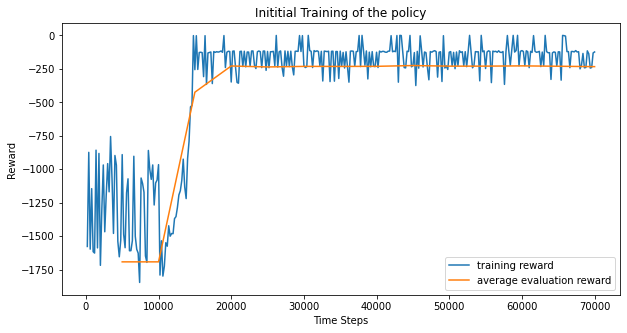

In [49]:
#Plot rewards during training
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(np.array(episode_rewards)[:,1],np.array(episode_rewards)[:,0], label = 'training reward')
plt.plot(np.array(evaluations)[:,1],np.array(evaluations)[:,0], label = 'average evaluation reward')
plt.title('Inititial Training of the policy')
plt.xlabel('Time Steps')
plt.ylabel('Reward')
plt.legend()

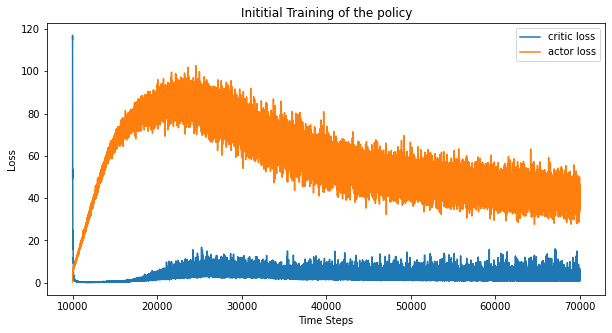

In [52]:
#Plot Losses of Actor and Critic during training
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(np.array(losses)[:,2],np.array(losses)[:,0], label = 'critic loss')
# plt.plot(np.array(losses)[::2,2],np.array(losses)[::2,1], label = 'actor loss') #Actor updates every other timestep
plt.plot(np.array(losses)[1::2,2],np.array(losses)[1::2,1], label = 'actor loss') #Actor updates every other timestep

plt.title('Inititial Training of the policy')
plt.xlabel('Time Steps')
plt.ylabel('Loss')
plt.legend()

## Visualize environment

In [ ]:
# !!! Currntly some issues with actually rendering it, so just saving actions and rendering it in a different notebook
eval_env = gym.make(env_id)
eval_env.seed(seed + 100) #get a different seed from before

avg_reward = 0.
actions = np.empty(0)
state, done = eval_env.reset(), False
while not done:
  action = policy.select_action(np.array(state))
  state, reward, done, _ = eval_env.step(action)
  avg_reward += reward
  actions = np.append(actions, action)
  # screen = eval_env.render(mode='rgb_array')

np.save('evaluation_actions',actions)

In [ ]:
from IPython.display import Image
!pip3 install numpngw
from numpngw import write_apng
from google.colab import files

In [ ]:
""" Modify Pendulum Environment to be able to use a mlp reward """
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import numpy as np
import gym
from gym import error, spaces, utils
from gym.utils import seeding
from gym.envs.classic_control.pendulum import PendulumEnv
import gym.envs.classic_control.pendulum

def angle_normalize(x):
    return (((x+np.pi) % (2*np.pi)) - np.pi)

class PendulumSSRLEnv(PendulumEnv):
    def __init__(self):
        super(PendulumSSRLEnv, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.T = env._max_episode_steps
        self._max_episode_steps = env._max_episode_steps
        self.RewardMLP = RewardNet((self.action_space.shape[-1] + self.observation_space.shape[-1])).to(self.device)
        self.D_piRL = None
        self.D_samp = None
        self.step_ = 0
        self.episode_train = 10
        self.state_action_record = []

    def step(self, u):
        th, thdot = self.state  # th := theta

        g = self.g
        m = self.m
        l = self.l
        dt = self.dt

        u = np.clip(u, -self.max_torque, self.max_torque)[0]
        self.last_u = u  # for rendering
        costs = angle_normalize(th) ** 2 + .1 * thdot ** 2 + .001 * (u ** 2)

        newthdot = thdot + (-3 * g / (2 * l) * np.sin(th + np.pi) + 3. / (m * l ** 2) * u) * dt
        newth = th + newthdot * dt
        newthdot = np.clip(newthdot, -self.max_speed, self.max_speed)

        self.state = np.array([newth, newthdot])

        # Add code to:
        #   * record state action results from the policy being learned 
        #   * add a row to D_samp after each episode 
        #   * stop and train every "episode_train" episodes 
        #   * record state 
        #   * Do a forward pass on the current state and action to get an estimated reward 
        self.state_action_record.extend((self._get_obs()[0], self._get_obs()[1], self._get_obs()[2], u)) 
        if ((self.step_ % self.T) == 0) and (self.step_ != 0):

            #print("self.D_samp.shape ", self.D_samp.shape)
            #print("np.array(self.state_action_record).reshape(1,-1) ", np.array(self.state_action_record).reshape(1,-1).shape)

            np.concatenate((self.D_samp, np.array(self.state_action_record).reshape(1,-1)[:,:800]))
            self.state_action_record = []
        if ((self.step_ % (self.T * self.episode_train)) == 0) and (self.step_ != 0):
            print("Training... ")
            self.train_reward()

        self.step_ += 1
        example = torch.tensor([self._get_obs()[0], self._get_obs()[1], self._get_obs()[2], u]).float().to(self.device)
        reward = float(self.RewardMLP(example))

        return self._get_obs(), reward, False, {}
        #return self._get_obs(), -costs, False, {}

    def generate_piRL_samples(self, env_piRL, model_piRL, num_piRL_samples=30):
        
        self.D_piRL = np.empty([num_piRL_samples, self.T*(self.action_space.shape[-1] + self.observation_space.shape[-1])])
        for i_episode in range(num_piRL_samples):
            ep = []
            obs = env_piRL.reset()
            for t in range(self.T):
                action = model_piRL.select_action(np.array(obs))
                ep.append(np.concatenate((obs,action)))
                obs, reward, done, _ = env_piRL.step(action) 

            self.D_piRL[i_episode,:] = np.array(ep).reshape(1,-1)

        self.D_samp = self.D_piRL.copy()
        print(np.shape(self.D_samp))

    def train_reward(self, num_train_stps=10, batch_size=4):
        
        model = self.RewardMLP.to(self.device)
        loss_func = RewardLoss()
        loss_func.requires_grad = True
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

        # Intialize Weights with He Initialization
        def weights_init(m):
            if (type(m) == torch.nn.Linear):
                torch.nn.init.kaiming_uniform_(m.weight)
        weights_init(model)

        D_train = np.concatenate((self.D_piRL, self.D_samp))

        for stp in range(num_train_stps):
            i = np.random.choice(D_train.shape[0], size=batch_size, replace=False)
            trajectory = torch.from_numpy(D_train[i].astype(np.float32)).float()
            
            # Compute Loss and train 
            loss = loss_func(self.D_piRL, self.D_samp, model)
            print("Loss: ", loss)
            optimizer.zero_grad()  
            loss.backward()        
            optimizer.step()       


# Calculate sum of rewards for one episode 
def get_return(model, trajectory):
    num_steps = trajectory.shape[-1]
    return_sum = 0
    for i in range(0, num_steps, 4):
        return_sum += model(torch.from_numpy(trajectory[i:i+4]).float().to(device))
    
    return return_sum 
                

class RewardLoss(nn.Module):
    def __init__(self):
        super(RewardLoss, self).__init__()
        self.max_torque = 2
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, D_piRL, D_samp, reward_model):
        """ Calculate (negative) log-likelihood of trajectories, reward model parameters   
        D_piRL: tensor of size (N, T*V)
        D_samp: tensor of size (M, T*V)
                N = num samples from piRL, M = num samples from piTheta (and piRL),
                T = episode length, V = (size of action space) + (size of observation space)
        reward_model: mlp, current estimate of reward function 

        return: Negative of eq. 3 from Generalizing Skills paper 
        """

        # Estimate partition function, Z 
        inner_sum = 0
        for i in range(D_samp.shape[0]):

            numerator = torch.exp(get_return(reward_model, D_samp[i,:]))
            denominator = 1 / (self.max_torque - (-1.0 * self.max_torque))
            inner_sum += (numerator/denominator)
        
        log_inner_sum = torch.log(inner_sum)

        # Now estimate Likelihood
        outer_sum = 0 
        for i in range(D_piRL.shape[0]):
            outer_sum += get_return(reward_model, D_piRL[i,:]) - log_inner_sum 
        
        return -1.0 * outer_sum 

class RewardNet(nn.Module):
    def __init__(self, input_size, h1_size=30, h2_size=30):
        super(RewardNet, self).__init__()

        # Inputs 
        self.input_size = input_size
        self.h1_size = h1_size
        self.h2_size = h2_size

        # Fully Connected Layers 
        self.linear1 = nn.Linear(self.input_size, self.h1_size)
        self.linear2 = nn.Linear(self.h1_size, self.h2_size)
        self.linear3 = nn.Linear(self.h2_size, 1)

        # Activations
        self.relu = nn.ReLU()
    
    def forward(self, input_data):
        out = self.relu(self.linear1(input_data))
        out = self.relu(self.linear2(out))
        return self.linear3(out)

In [ ]:
!pip install stable-baselines3[extra] pybullet

from stable_baselines3.common.env_checker import check_env

In [ ]:
env = gym.make(env_id) #Before we init the PendulumSSRLEnv there must be some env to get max timesteps values from
custom_pendulum_env = PendulumSSRLEnv()
check_env(custom_pendulum_env, warn=True)

/usr/local/lib/python3.6/dist-packages/stable_baselines3/common/env_checker.py:232: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


In [ ]:
custom_pendulum_env.generate_piRL_samples(env_piRL=env, model_piRL=policy)


In [ ]:
#Crate new variables for env( just in case) and model (must do) to do new training
env1 = copy.deepcopy(custom_pendulum_env)

#Reseed the environment (again, for consistency), torch, numpy
#Will need to find an optimal seed eventually
seed=0 # Sets Gym, PyTorch and Numpy seeds
env1.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)


kwargs = {
		"state_dim": state_dim,
		"action_dim": action_dim,
		"max_action": max_action,
		"discount": discount,
		"tau": tau,
	}

# Target policy smoothing is scaled wrt the action scale
kwargs["policy_noise"] = policy_noise * max_action
kwargs["noise_clip"] = noise_clip * max_action
kwargs["policy_freq"] = policy_freq
policy1 = TD3(**kwargs)

In [ ]:
#To save models while training:
save_model = True
file_name = 'Test1'
#Training
replay_buffer = ReplayBuffer(state_dim, action_dim)
	
# Evaluate untrained policy
evaluations1 = []
episode_rewards1 = []
losses1 = []

state, done = env1.reset(), False
episode_reward = 0
episode_timesteps = 0
episode_num = 0

for t in range(int(max_timesteps)):
  
  episode_timesteps += 1

  # Select action randomly or according to policy
  if t < start_timesteps:
    action = env1.action_space.sample()
  else:
    action = (
      policy1.select_action(np.array(state))
      + np.random.normal(0, max_action * expl_noise, size=action_dim)
    ).clip(-max_action, max_action)

  # Perform action
  next_state, reward, done, _ = env1.step(action) 
  done_bool = float(done) if episode_timesteps < env1._max_episode_steps else 0

  # Store data in replay buffer
  replay_buffer.add(state, action, next_state, reward, done_bool)

  state = next_state
  episode_reward += reward

  # Train agent after collecting sufficient data
  if t >= start_timesteps:
    loss_critic, loss_actor = policy1.train(replay_buffer, batch_size)
    losses1.append([loss_critic, loss_actor, t+1]) #saving for plotting

  if done: 
    # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
    print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
    episode_rewards.append([episode_reward, t+1]) #saving for plotting
    # Reset environment
    state, done = env1.reset(), False
    episode_reward = 0
    episode_timesteps = 0
    episode_num += 1 

  # Evaluate episode
  if (t + 1) % eval_freq == 0:
    evaluations1.append([eval_policy(policy, env_id, seed), t+1] )
    np.save(f"results_{t+1}_{file_name}", evaluations)
    if save_model:
       policy1.save(f"models_{t+1}_{file_name}")
      #  files.download(f'{name}.zip') 

NameError: ignored

In [ ]:
#Plot rewards during training
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(np.array(episode_rewards)[:,1],np.array(episode_rewards)[:,0], label = 'training reward')
plt.plot(np.array(evaluations)[:,1],np.array(evaluations)[:,0], label = 'average evaluation reward')
plt.title('Inititial Training of the policy')
plt.xlabel('Time Steps')
plt.ylabel('Reward')
plt.legend()

In [ ]:
#Plot Losses of Actor and Critic during training
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(np.array(losses)[:,2],np.array(losses)[:,0], label = 'critic loss')
plt.plot(np.array(losses)[::2,2],np.array(losses)[::2,1], label = 'actor loss') #Actor updates every other timestep
plt.title('Inititial Training of the policy')
plt.xlabel('Time Steps')
plt.ylabel('Loss')
plt.legend()